# KdV Uncertainty output

## Plots

Produce the following plots:
 - Example a0 and density profiles for one time step
 - Example of a time-series all A(t) for 1, 10, 500 runs
 - Timeseries of 'max_amplitude' all runs
 - Timeseries of normalized 'max_amplitude' all runs
 
---
Other plots for the paper/talks:
 - *Example of scenario A(x,t)* requires running a simulation...

In [17]:
import h5py
from glob import glob
import numpy as np
from datetime import datetime

import pandas as pd
import xarray as xr

from dask import array as da
from dask import delayed

from iwaves.utils import isw

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

plt.rcParams.update({'font.size': 18})

%matplotlib inline

# Test loading some data

Data are stored in individual hdf5 files for each step (1473) and each sample (500)

In [18]:
#sorted(glob("../../shiny_dashboard/data/timepoint-1/all_amplitudes/*.h5"))

def get_file_name(timepoint, sample):
    return "../../kdv_solutions_azure/shiny_dashboard/data/timepoint-%d/all_amplitudes/2018-07-24--13-00-34_timepoint-%d_sample-%d_output.h5"%(timepoint,timepoint,sample)

def get_all_file(timepoint):
    return sorted(glob("../../kdv_solutions_azure/shiny_dashboard/data/timepoint-%d/all_amplitudes/*.h5"%(timepoint)))

def get_summary_file(timepoint):
    return sorted(glob("../../kdv_solutions_azure/shiny_dashboard/data/timepoint-%d/*.h5"%(timepoint)))[0]
#get_file_name(1,0)
#get_all_file(1)
get_summary_file(1)

'../../kdv_solutions_azure/shiny_dashboard/data/timepoint-1/2018-07-24--13-00-34_slim-output.h5'

In [19]:
h5 = h5py.File(get_summary_file(1),'r')
list(h5.keys())

['a0_samples', 'beta_samples', 'max_amplitude', 'timepoint']

In [20]:
h5['a0_samples'][:].shape

(500,)

In [21]:
h5['beta_samples'][:].shape

(6, 500)

In [22]:
h5['max_amplitude'].value.shape

(500,)

In [23]:
#h5['amplitudes'].shape

# Data loading tools

In [24]:
#@delayed(nout=1)
def load_h5_step_old(varname, timepoint):
    nsamples = 500

    a0 = []
    for ii in range(nsamples):
        try:
            h5 = h5py.File(get_file_name(timepoint,ii),'r')
            a0.append(da.from_array( h5[varname].value, chunks=-1))
            h5.close()
        except:
            continue
            #print('Failed to load sample %d...'%ii)
    
    if len(a0) == 0:
        print('No files found for step %d'%timepoint)
    a0_da = da.stack(a0)

    return a0_da

def load_h5_step(varname, timepoint):
    files = get_all_file(timepoint)
    nsamples = len(files)

    a0 = []
    for ii in range(nsamples):
        h5 = h5py.File(files[ii],'r')
        a0.append(da.from_array( h5[varname].value, chunks=-1))
        h5.close()

    a0_da = da.stack(a0)

    return a0_da

@delayed(nout=1)
def load_h5_alltime(varname, maxpoints):

    a0 = []
    for ii in range(maxpoints):
        a0_da = load_h5_step(varname, ii)
        a0.append(a0_da)
        
    #a0_t = da.stack(a0, axis=0)
    
    return a0

def return_a0_beta(timestep, ensemble):
    h5 = h5py.File(get_summary_file(timestep),'r')
    a0 = h5['a0_samples'][ensemble]
    beta = h5['beta_samples'][:,ensemble]
    h5.close()
    
    return a0, beta

def return_max_ensemble(timestep):
    h5 = h5py.File(get_summary_file(timestep),'r')
    a0 = h5['max_amplitude'][:]
    h5.close()
    
    return np.argwhere(np.abs(a0) == np.abs(a0).max())[0,0]
#amp, beta, a0 = load_h5_step(1)

return_max_ensemble(1)

160

In [25]:
tstep = 50
a0 = load_h5_step('a0_sample', tstep).compute()
beta = load_h5_step('beta_samples', tstep).compute()
amax = load_h5_step('max_amplitude', tstep).compute()

#a0 = load_h5_alltime('beta_samples',10)
#a0 = a0.compute()
#beta = beta.compute()

# Load the raw csv data

In [26]:
def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt

def read_density_csv(csvfile):
    # Reads into a dataframe object
    df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)

    # Load the csv data
    depths= np.array([float(ii) for ii in df.columns.values])
    rho_obs_tmp = df[:].values.astype(float)
    time = df.index[:]

    # Clip the top
    rho_obs_2d = rho_obs_tmp[:,:]

    # Remove some nan
    fill_value = 1024.
    rho_obs_2d[np.isnan(rho_obs_2d)] = fill_value
    
    return xr.DataArray(rho_obs_2d,dims=('time', 'depth'),
            coords={'time':time.values,'depth':depths})



In [27]:
datadir = '../../run_ddcurves/'
datafile1 = '%s/DATA_QC/Crux_KP150_Phs1_Density_lowpass'%datadir
datafile2 = '%s/DATA_QC/Crux_KP150_Phs2_Density_lowpass'%datadir
sitename = 'CRUX'

rho1 = read_density_csv('%s.csv'%datafile1)
rho2 = read_density_csv('%s.csv'%datafile2)

rho = xr.concat([rho1,rho2], dim='time')
rho

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


<xarray.DataArray (time: 1481, depth: 12)>
array([[1026.1856, 1025.8925, 1025.7143, ..., 1021.5415,       nan, 1021.0069],
       [1026.1849, 1025.8863, 1025.7151, ..., 1021.3722,       nan, 1021.0062],
       [1026.1869, 1025.8835, 1025.7203, ..., 1021.2284,       nan, 1021.0056],
       ...,
       [1026.0198, 1025.7399, 1025.5525, ..., 1021.5754, 1021.5571, 1021.5513],
       [1026.0087, 1025.7564, 1025.5539, ..., 1021.5695, 1021.5503, 1021.544 ],
       [1026.017 , 1025.7993, 1025.583 , ..., 1021.6404, 1021.6203, 1021.6138]])
Coordinates:
  * depth    (depth) float64 -250.5 -227.8 -203.6 -179.4 -155.2 -131.0 ...
  * time     (time) datetime64[ns] 2016-04-29T23:15:00 2016-04-30T05:15:00 ...

# Plot of some initial conditions for one scenario

In [28]:
def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
                + np.tanh((z+beta[4])/beta[5]))

In [29]:
# Depth
zmin = -250
zout = np.linspace(zmin,0,100)

Text(0,0.5,'Count')

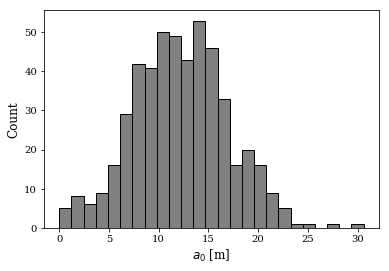

In [30]:
plt.figure()
plt.hist(a0,bins=25, color='0.5', edgecolor='k')
plt.xlabel('$a_0$ [m]')
plt.ylabel('Count')

Text(0.5,0,'$\\rho$ [kg m$^{-3}$]')

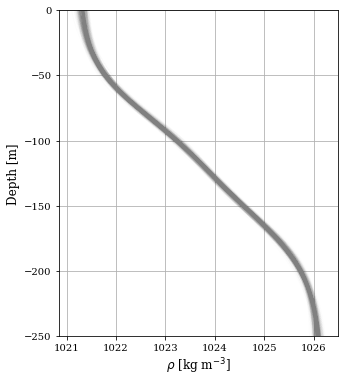

In [31]:
# Plot the density profile
plt.figure(figsize=(5,6))
nsamples = 500
for rand_loc in range(0, nsamples):
    rhotmp = double_tanh(beta[rand_loc,:], zout)
    plt.plot(rhotmp, zout, '0.5', lw=1, alpha=0.02)
    
#plt.plot(rhomean*RHO0, zout, 'k--',) # Mean fit

plt.grid(b=True)
plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
#plt.title(rho.time.values[tstep])

In [32]:
# Calculate alpha, cn for a time step

def calc_alpha(beta, zout, nsamples=500, mode=0):
    
    alpha_ens = np.zeros((nsamples,))
    c_ens = np.zeros((nsamples,))

    dz = np.diff(zout).mean()
    
    for ii in range(nsamples):
        rhotmp = double_tanh(beta[ii,:], zout)

        N2 = -9.81/1000*np.gradient(rhotmp,dz)

        phi,cn = isw.iwave_modes(N2, dz)

        phi_1 = phi[:,mode]
        phi_1 =phi_1 / np.abs(phi_1).max()
        phi_1 *= np.sign(phi_1.sum())

        alpha = isw.calc_alpha(phi_1, cn[mode],N2,dz)

        alpha_ens[ii] = alpha
        c_ens[ii] = cn[mode]
        
    return alpha_ens, c_ens

In [33]:
alpha, cn = calc_alpha(beta, zout)

T = 12.42*3600.
omega = 2*np.pi / T
Ls = cn**2. / (np.abs(alpha)*a0*omega) 
Ls

array([8.96290059e+05, 1.54378421e+06, 8.99008465e+05, 1.12754898e+06,
       7.67136397e+05, 7.42364553e+05, 3.40727120e+05, 4.74805051e+05,
       3.50910717e+05, 3.07785526e+05, 8.04543001e+06, 2.87049576e+06,
       7.72525351e+05, 4.33914299e+05, 6.05574113e+05, 8.48597719e+05,
       6.40095592e+05, 7.25511170e+05, 5.09785886e+05, 4.76927111e+05,
       4.33452585e+05, 9.18104527e+05, 7.04851082e+05, 4.94513867e+05,
       5.82960466e+05, 8.40990706e+05, 1.01493416e+06, 6.15014984e+05,
       7.88900144e+05, 6.61348824e+05, 6.76210174e+05, 6.91888358e+05,
       7.65918247e+05, 1.00272733e+06, 8.62221444e+05, 6.45219431e+05,
       1.50698156e+06, 3.84611693e+05, 5.49671584e+05, 3.81926454e+05,
       8.86719307e+05, 6.64061230e+05, 8.02047059e+05, 5.52596483e+05,
       4.53160993e+05, 8.51053218e+05, 6.63875130e+05, 6.77067544e+05,
       5.78814405e+05, 4.98149132e+05, 6.65014762e+05, 2.95020355e+06,
       2.76737575e+05, 9.78336243e+05, 4.73632256e+05, 1.26129686e+06,
      

Text(0.5,0,'$Ls$ [m]')

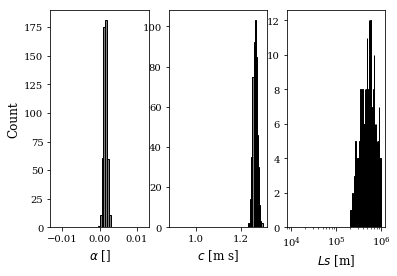

In [34]:
plt.figure()
plt.subplot(131)
plt.hist(alpha,bins=np.arange(-0.012,0.01205,0.0005), color='0.5', edgecolor='k')
plt.xlabel(r'$\alpha$ []')
plt.ylabel('Count')

plt.subplot(132)
plt.hist(cn,bins=np.arange(0.9,1.3,0.005), color='0.5', edgecolor='k')
plt.xlabel(r'$c$ [m s]')

plt.subplot(133, xscale='log')
plt.hist(Ls,bins=np.arange(10e3,1000000,10e3), color='0.5', edgecolor='k')
plt.xlabel(r'$Ls$ [m]')
#plt.ylabel('Count')

(-3.5, 3.5)

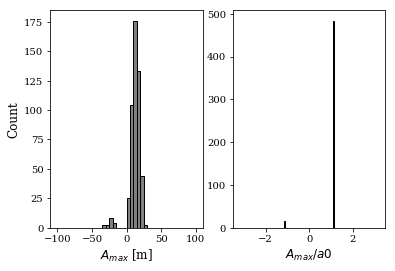

In [35]:
plt.figure()
plt.subplot(121)
plt.hist(amax,bins=np.arange(-100,105,5), color='0.5', edgecolor='k')
plt.xlabel(r'$A_{max}$ [m]')
plt.ylabel('Count')

plt.subplot(122)
plt.hist(amax/a0,bins=np.arange(-3.5,3.55,0.05), color='0.5', edgecolor='k')
plt.xlabel(r'$A_{max}/a0$')
plt.xlim(-3.5,3.5)


Text(0.5,0,'$L_s / L$')

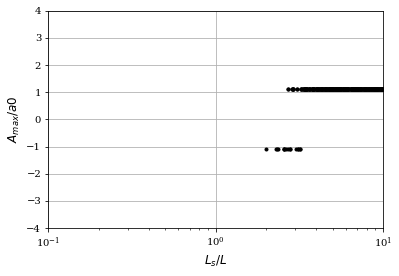

In [36]:
L = 1e5 # Location of output point

plt.semilogx(Ls/L, amax/a0, 'k.')
plt.xlim(1e-1,10)
plt.ylim(-4,4)
plt.grid(b=True)

plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')


In [37]:
# Plot the amplitudes for all runs
amp = load_h5_step('amplitudes', tstep).compute()# Amplitudes are stored from last to first

dt = 20
nt = amp.shape[1]
time = np.arange(0,nt)*dt

Text(0.5,0,'time [cycles]')

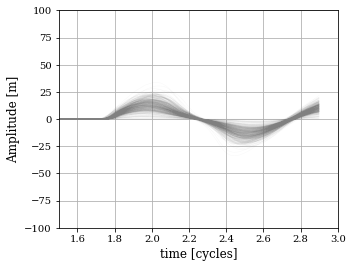

In [38]:
plt.figure(figsize=(5,4))
nsamples = 500
for rand_loc in range(0, nsamples):
    plt.plot(time/T, amp[rand_loc,:], '0.5', lw=0.5, alpha=0.05)
    
#plt.plot(rhomean*RHO0, zout, 'k--',) # Mean fit

plt.grid(b=True)
plt.ylim(-100,100 )
plt.xlim(1.5,3)
plt.ylabel('Amplitude [m]')
plt.xlabel(r'time [cycles]')

In [39]:
# Get amax/a0 for all steps
nt = 1473
nsamples = 500
amax_t = np.zeros((nsamples,nt))
a0_t = np.zeros((nsamples,nt))
alpha_t = np.zeros((nsamples,nt))
cn_t = np.zeros((nsamples,nt))
beta_t = np.zeros((nt, nsamples,6))

In [48]:
for ii in tqdm(range(0,nt)):
    try:
        a0_tmp = load_h5_step('a0_sample', ii+1).compute()
        amax_tmp = load_h5_step('max_amplitude', ii+1).compute()
        beta_tmp = load_h5_step('beta_samples', ii+1).compute()

        ns = a0_tmp.shape[0]
        if ns < 500:
            print('Only found %d sample for step %d'%(ns,ii))
        alpha_tmp, c_tmp = calc_alpha(beta_tmp, zout, nsamples=ns, mode=0)    

        a0_t[0:ns,ii] = a0_tmp
        amax_t[0:ns,ii] = amax_tmp
        alpha_t[0:ns,ii] = alpha_tmp
        cn_t[0:ns,ii] = c_tmp

        beta_t[ii,0:ns,:] = beta_tmp
    except:
        print('Timestep %d failed to load data'%(ii))




    #    ngood = a0_tmp.shape[0]
    #    
    #    a0_t[0:ngood,ii] = a0_tmp
    #    amax_t[0:ngood:,ii] = amax_tmp
    #except:
    #    print('Failed to load step %d...'%ii)

 29%|██▉       | 433/1473 [1:17:14<3:05:30, 10.70s/it]

Only found 173 sample for step 433


100%|██████████| 1473/1473 [4:27:20<00:00, 10.89s/it]  

Timestep 1472 failed to load data


In [49]:
# Create an xray dataset with the output
dims2 = ('ensemble','time')
dims3 = ('time','ensemble','params')

time = rho.time.values
time = range(nt)
coords2 = {'time':time, 'ensemble':range(nsamples)}
coords3 = {'time':time, 'ensemble':range(nsamples), 'params':range(6)}
           
amax_da = xr.DataArray(amax_t,
                coords=coords2,
                dims=dims2,
                attrs={'long_name':'', 'units':''},
                )
           
a0_da = xr.DataArray(a0_t,
    coords=coords2,
    dims=dims2,
    attrs={'long_name':'', 'units':''},
    )

cn_da = xr.DataArray(cn_t,
    coords=coords2,
    dims=dims2,
    attrs={'long_name':'', 'units':''},
    )

alpha_da = xr.DataArray(alpha_t,
    coords=coords2,
    dims=dims2,
    attrs={'long_name':'', 'units':''},
    )

beta_da = xr.DataArray(beta_t,
    coords=coords3,
    dims=dims3,
    attrs={'long_name':'', 'units':''},
    )

dsout = xr.Dataset({'amax':amax_da, 'a0':a0_da, 'cn':cn_da, 'alpha':alpha_da, 'beta':beta_da})
dsout

<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 1473)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    amax      (ensemble, time) float64 -5.948 -13.36 2.973 -16.09 6.721 ...
    a0        (ensemble, time) float64 5.396 12.12 2.691 14.58 6.101 11.55 ...
    cn        (ensemble, time) float64 1.283 1.28 1.282 1.263 1.271 1.275 ...
    alpha     (ensemble, time) float64 0.006589 0.006453 0.007269 0.005735 ...
    beta      (time, ensemble, params) float64 1.023e+03 1.267 60.8 24.98 ...

In [50]:
dsout.to_netcdf('../../kdv_solutions_azure/kdv_all_ensembles.nc')

In [ ]:
A_t = amax_t/a0_t

plt.plot(A_t.min(axis=0))

In [ ]:
a0_tmp = load_h5_step('a0_sample', 50).compute()
